In [7]:
%load_ext autoreload
%autoreload 2
import os

import mlflow
import numpy as np
from dotenv import load_dotenv

from src.functions import create_model, plot_data, check_gpus, create_train_val_datasets, load_stations_from_path, \
    create_test_datasets, plot_keras_history, get_features_and_targets
from src.utils import now_formatted, setup_logger, format_with_border, measure_execution_time

2023-11-26 15:09:34.350708: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-26 15:09:34.350789: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-26 15:09:34.350854: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-26 15:09:34.362038: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
import numpy as np
import warnings

def replicate_seasonal_pattern(df, column_name):
    yearly_data = df.resample('Y').count()
    max_count = yearly_data.max().iloc[0]
    first_full_year = yearly_data[yearly_data[column_name] == max_count].index[0].year

    if max_count < 365:
        return df

    period_arrays = []

    for year in range(first_full_year, first_full_year + 3):
        start_date = f'{year}-01-01'
        end_date = f'{year}-12-31'
        if start_date in df.index and end_date in df.index:
            typical_period = df.loc[start_date:end_date, column_name]
            period_arrays.append(typical_period.values)

    if len(period_arrays) < 3:
        return df

    min_length = min(len(arr) for arr in period_arrays)
    period_arrays = [arr[:min_length] for arr in period_arrays]
    combined_mean = np.mean(period_arrays, axis=0)

    repeat_times = len(df) // len(combined_mean) + 1
    fill_pattern = np.tile(combined_mean, repeat_times)[:len(df)]
    
    df[column_name].fillna(pd.Series(fill_pattern, index=df.index), inplace=True)

    return df

def fill_with_seasonal_average(df, column_name):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        df = df.copy()
        
        if not df[column_name].notnull().any():
            return df
        
        df['temp'] = df[column_name].fillna(df[column_name].mean())

        decompose = seasonal_decompose(df['temp'], model='additive', period=365)
        seasonal = decompose.seasonal

        average_seasonal = seasonal.groupby(df.index.to_period('2W')).mean()

        missing_values = df[column_name].isna()

        for period in average_seasonal.index:
            df.loc[(missing_values) & (df.index.to_period('2W') == period), column_name] = average_seasonal[period]

        df.drop('temp', axis=1, inplace=True)

        return df

import pandas as pd
import os

dfs = []

read_path = '../data/labeled'
test_path = '../data/labeled_benchmark/test'
train_path = '../data/labeled_benchmark/train'

files = os.listdir(read_path)

for i, f in enumerate(files):
    print(i, f[:-4])
    # if i != 1:
    #     continue
    df = pd.read_csv(os.path.join(read_path, f))
    df['measure_date'] = pd.to_datetime(df['measure_date'])
    station_code = f[:-4]

    df.set_index('measure_date', drop=True, inplace=True)
    cols = [
        'HS',
        'TSS_30MIN_MEAN',
        'TS0_30MIN_MEAN',
        'RSWR_30MIN_MEAN',
        'TA_30MIN_MEAN',
        'VW_30MIN_MEAN',
        'no_snow'
    ]
    # cols = ['HS', 'TSS_30MIN_MEAN', 'RSWR_30MIN_MEAN', 'TA_30MIN_MEAN', 'VW_30MIN_MEAN', 'no_snow']
    df = df[cols]

    # aggregations = {c: lambda x: x.mean() if pd.notnull(x.mean()) else 0 for c in cols}
    aggregations = {c: 'mean' for c in cols}
    aggregations['no_snow'] = lambda x: x.value_counts().idxmax()
    
    df = df.resample('D').agg(aggregations)

    for col in cols[:-1]:
        if df[col].notnull().any():
            df[col] = replicate_seasonal_pattern(df, col)[col]
        else:
            df[col] = df[col].fillna(-1000000) # If these are only null values
            print(f"Only null: {station_code} {col}")

    df['station_code'] = station_code
    dfs.append(df) # Avoid missing the index
    df.reset_index(inplace=True)

    save_path = test_path if station_code in ['STN2', 'SHE2', 'TRU2', 'WFJ2', 'SLF2', 'KLO2'] else train_path
    df.to_csv(os.path.join(save_path, f))

    # dfs.append(df)

0 AMD2
1 LAG3
2 FNH2
3 GUT2
4 KLO2
5 TUM2
6 SHE2
7 ARO3
8 BOR2
Only null: BOR2 TS0_30MIN_MEAN
9 SLF2
10 FLU2
11 GLA2
12 STN2
13 TRU2
14 SPN2
15 KLO3
16 RNZ2
17 ILI2
18 FOU2
Only null: FOU2 TS0_30MIN_MEAN
19 WFJ2


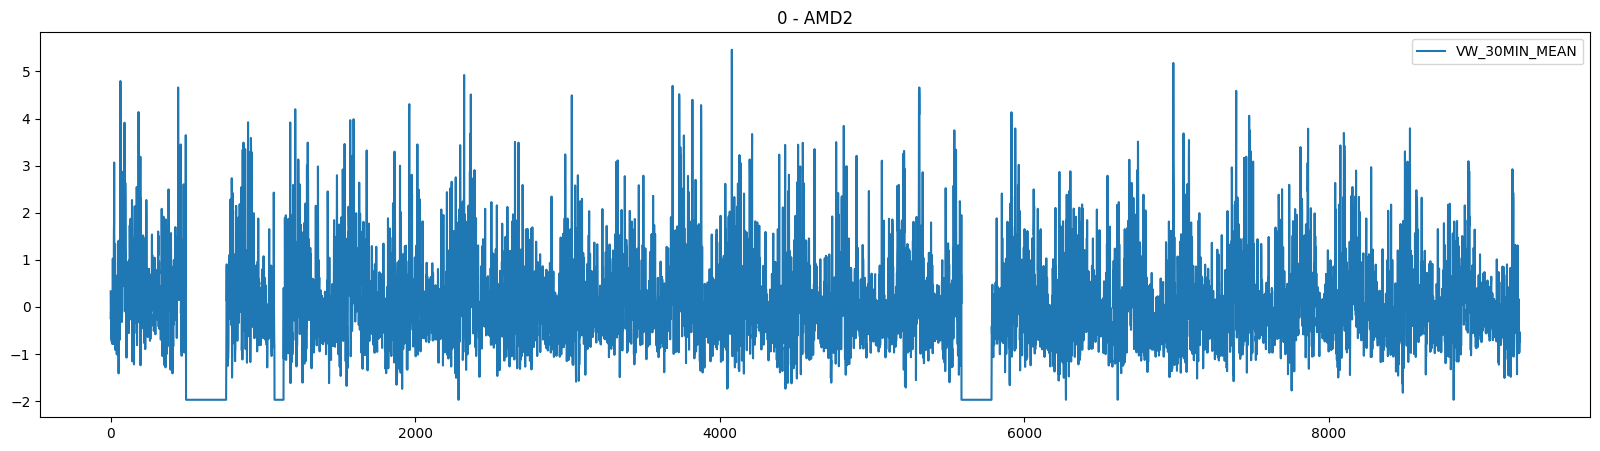

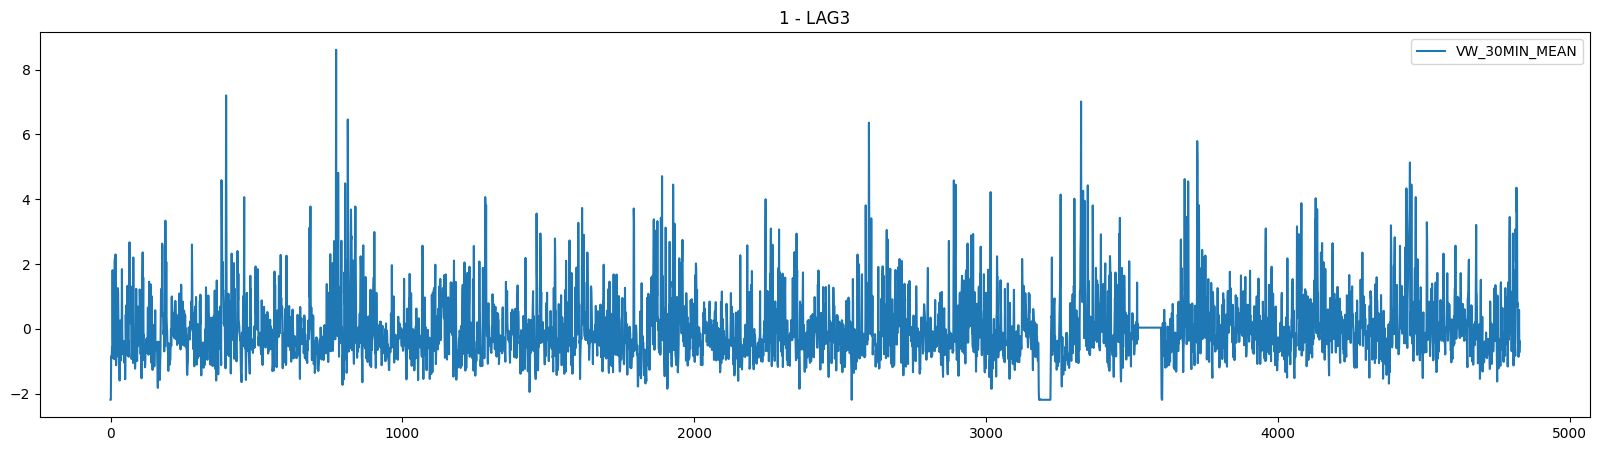

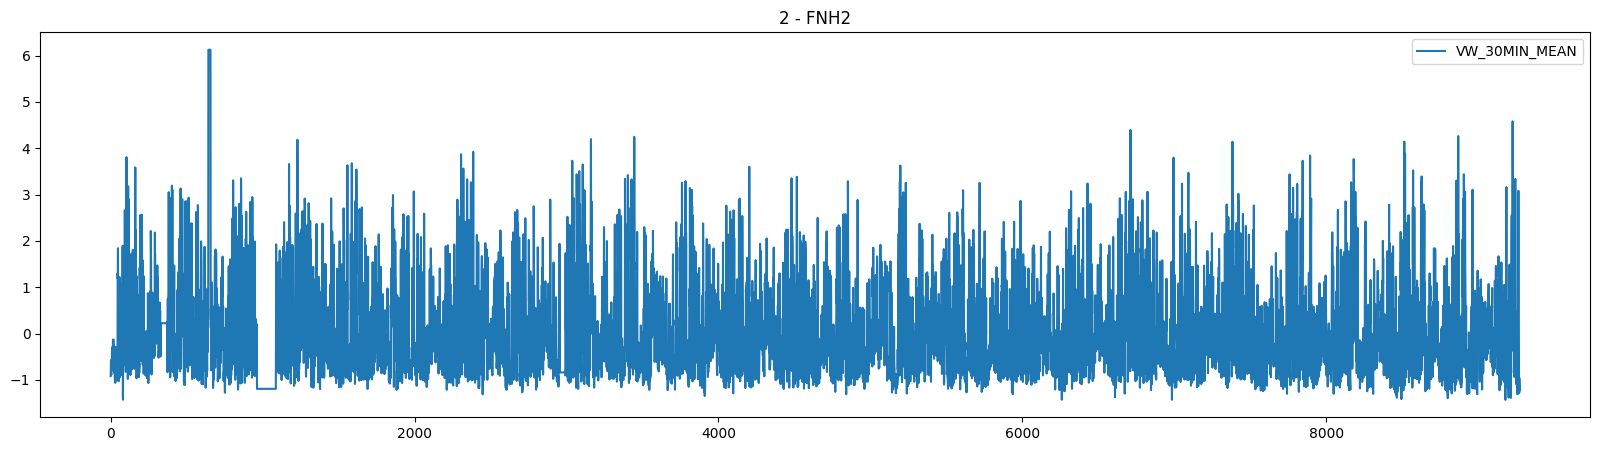

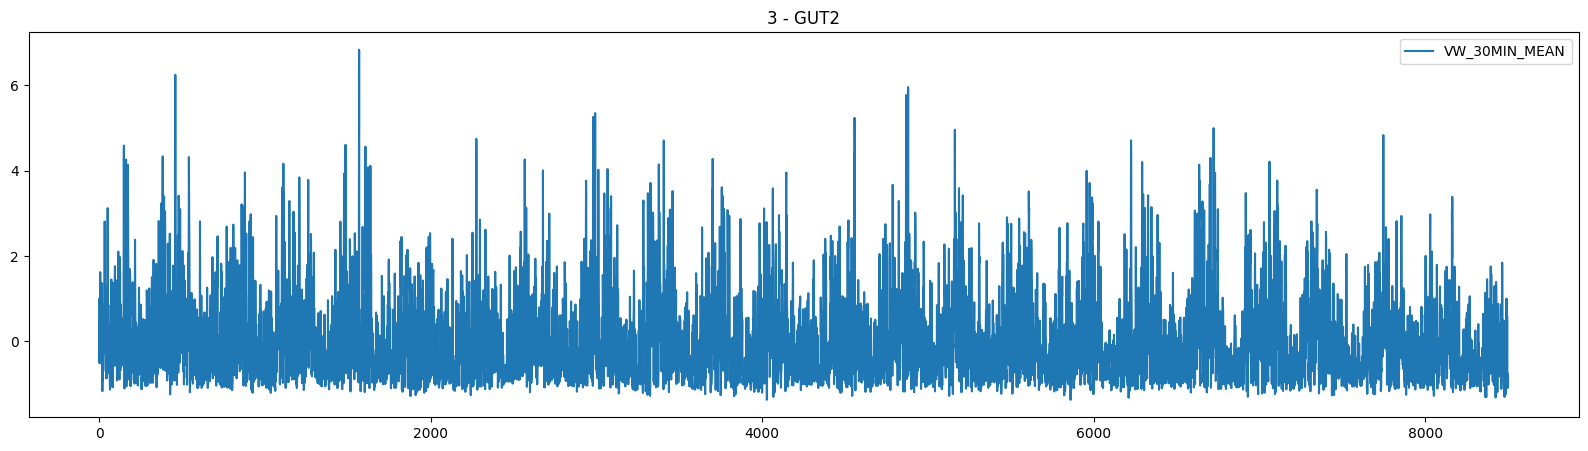

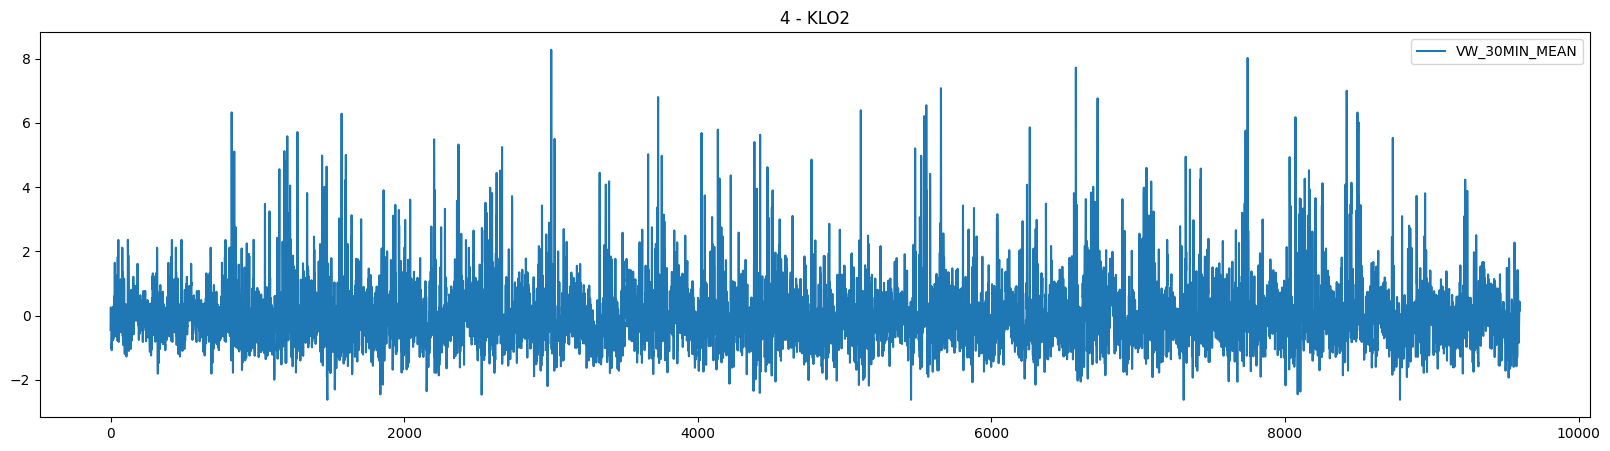

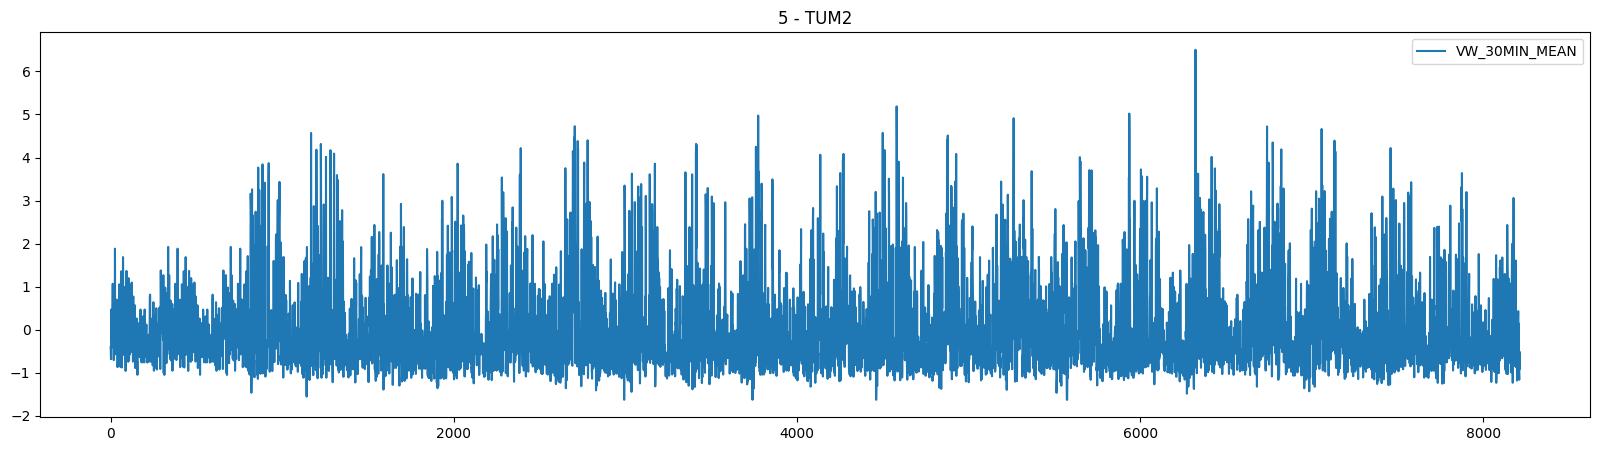

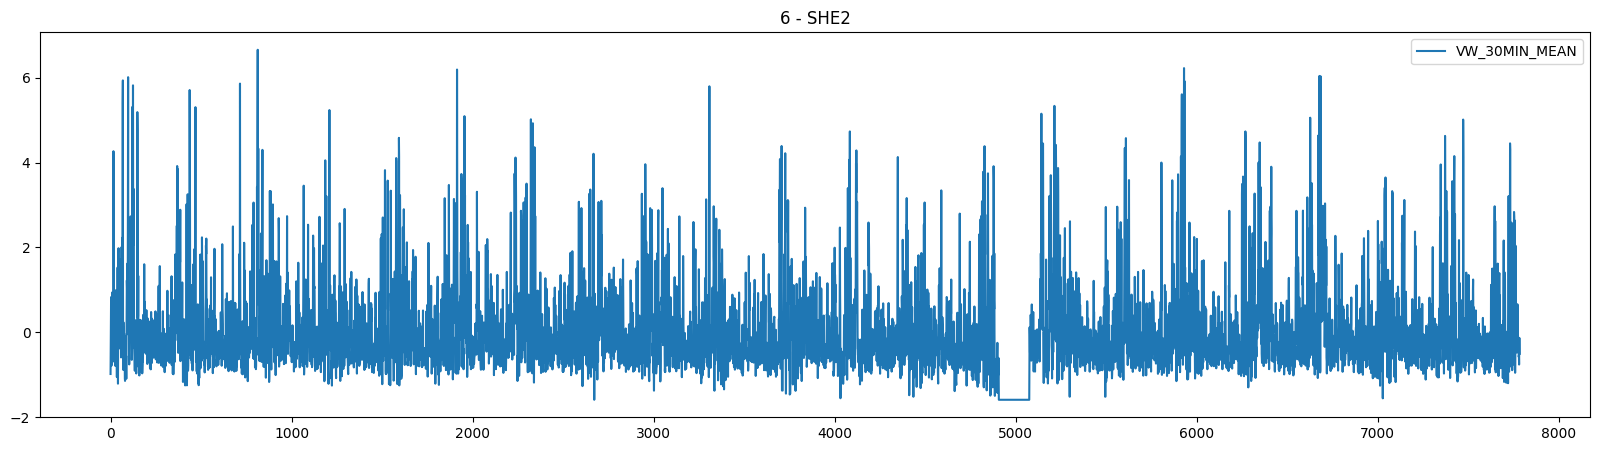

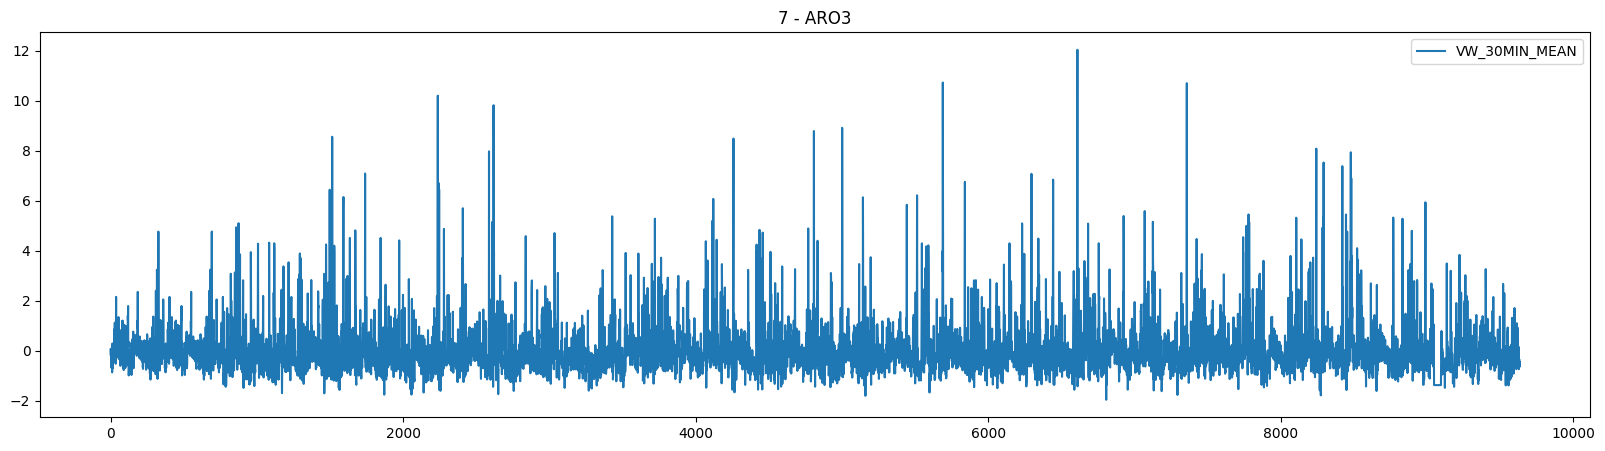

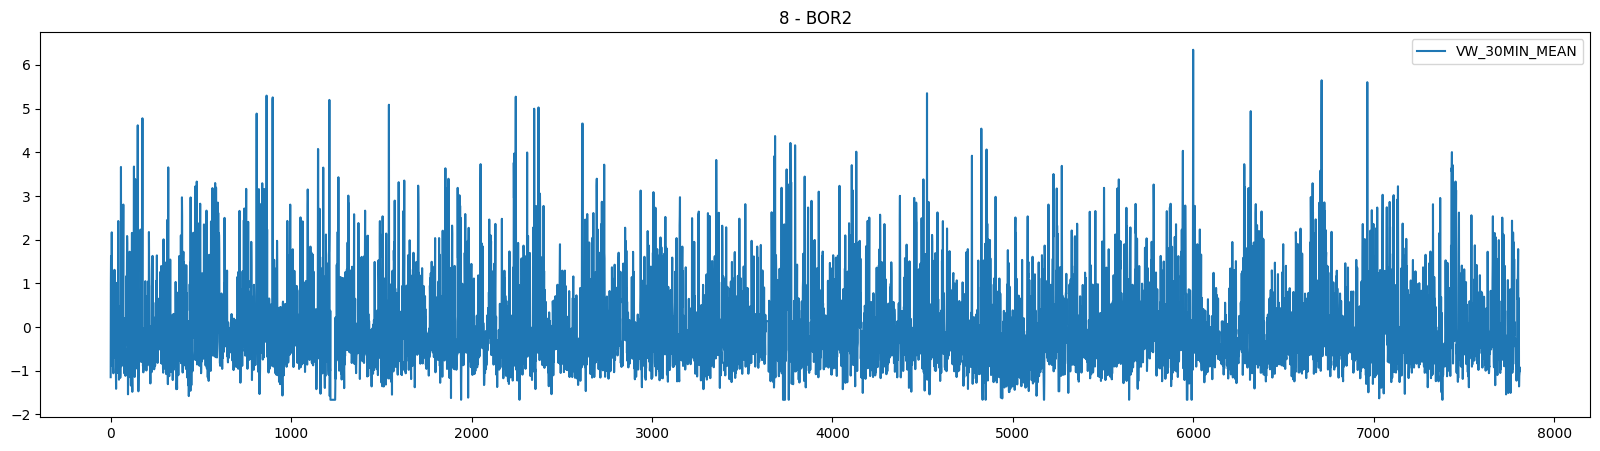

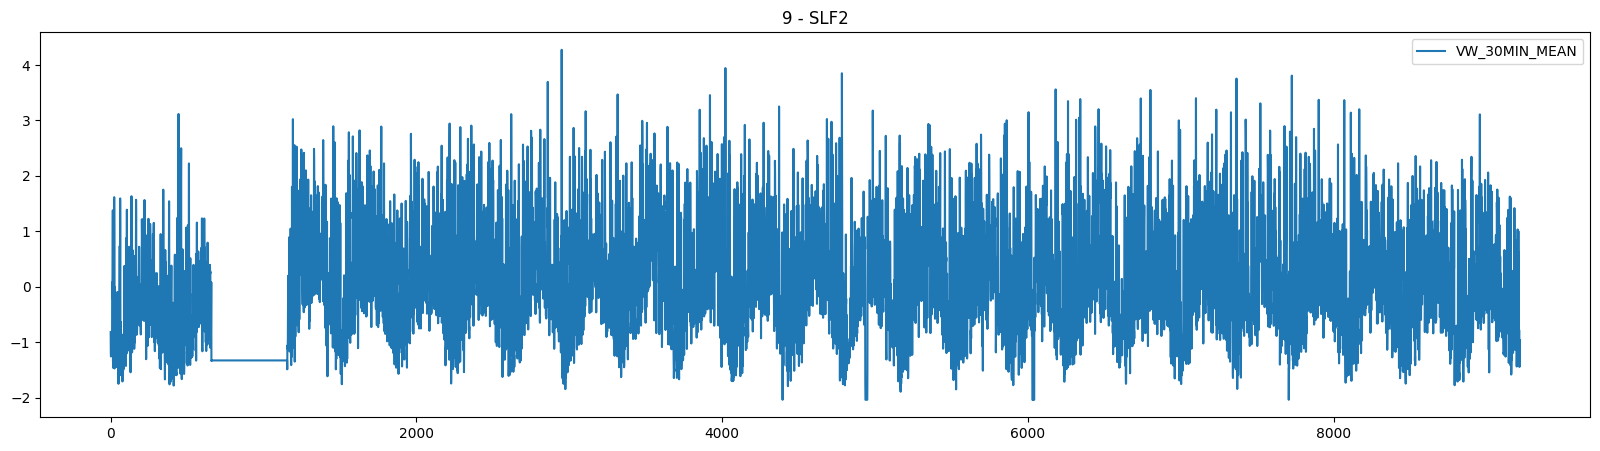

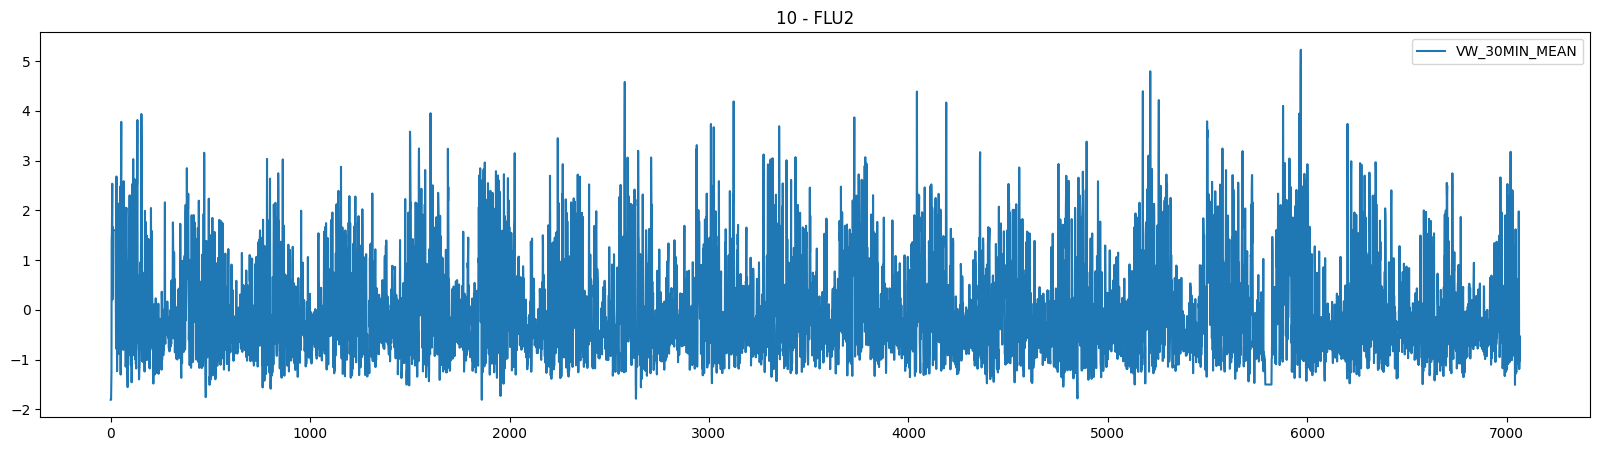

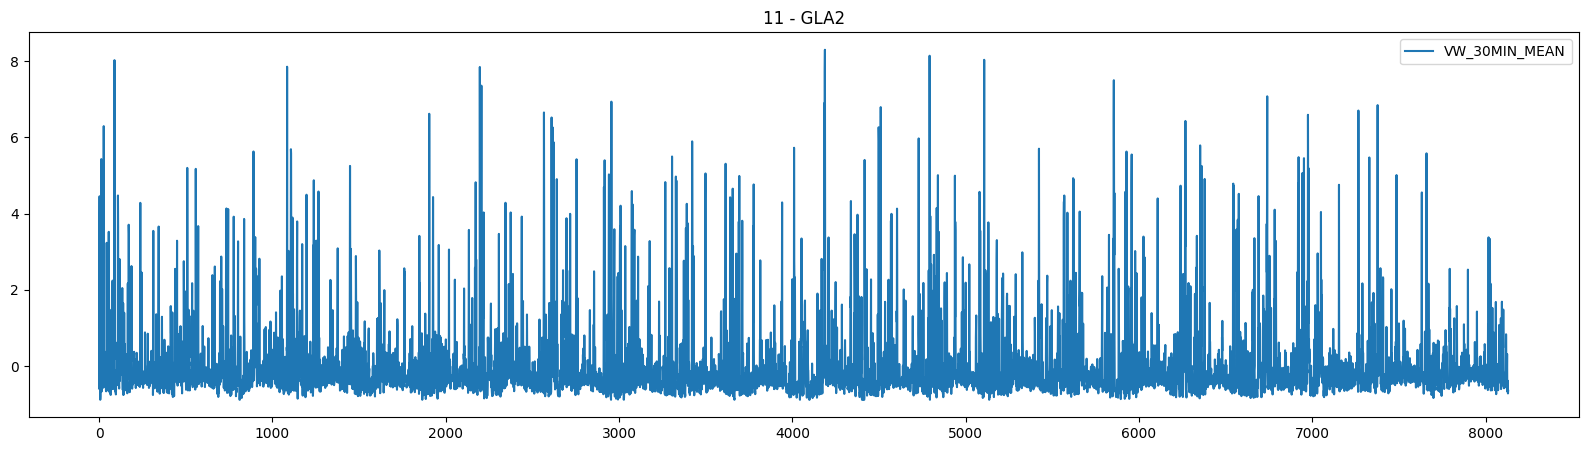

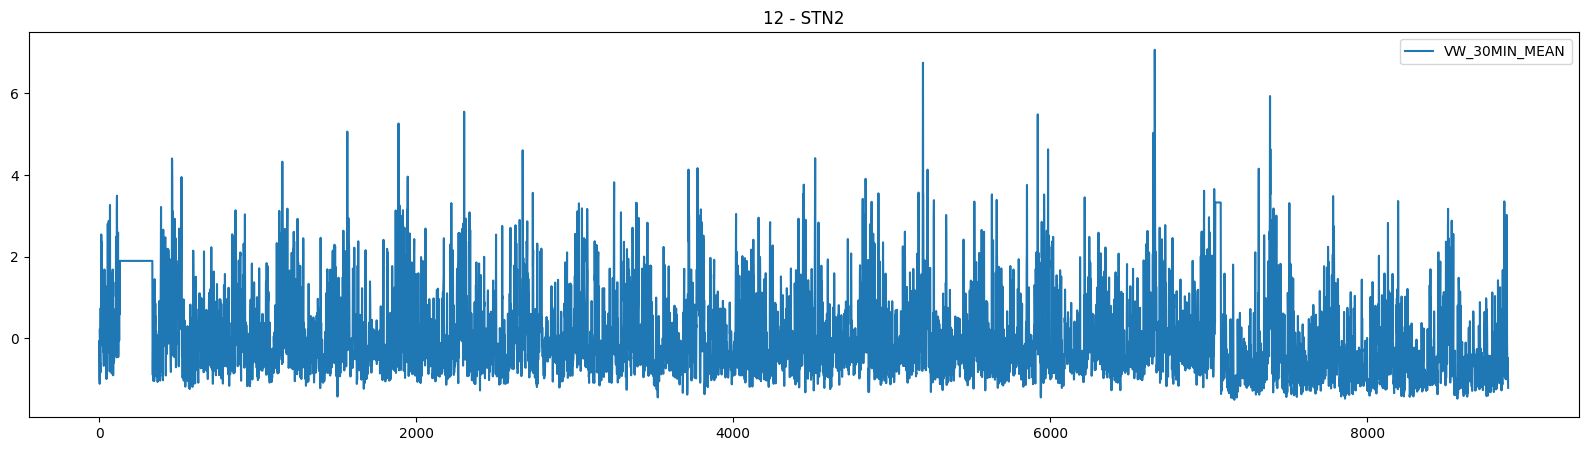

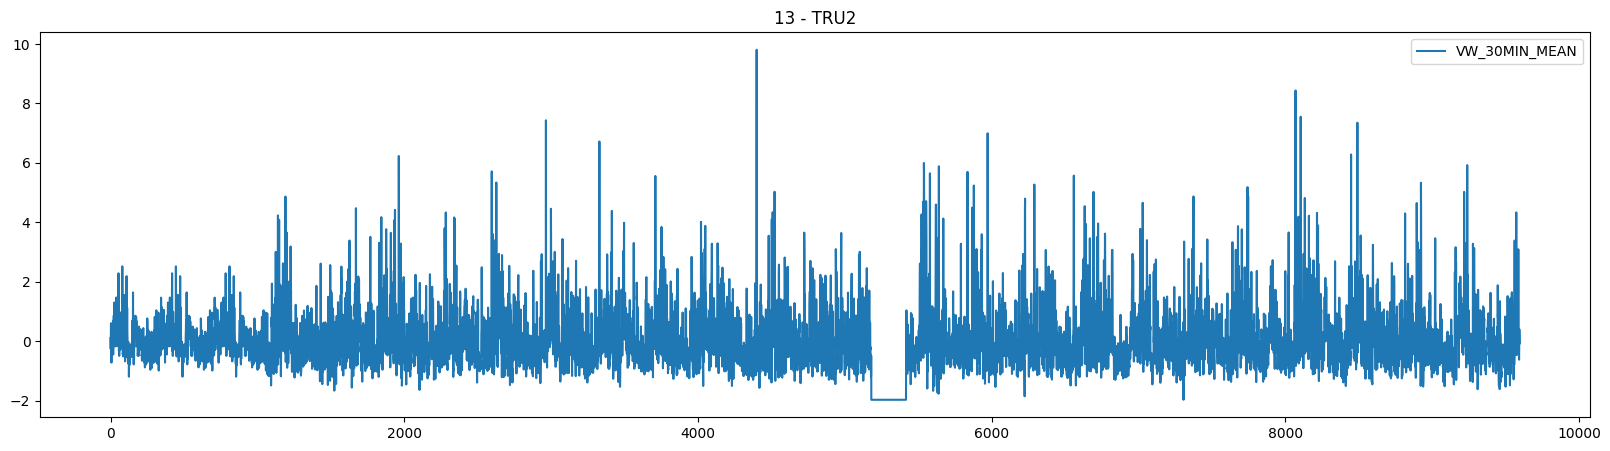

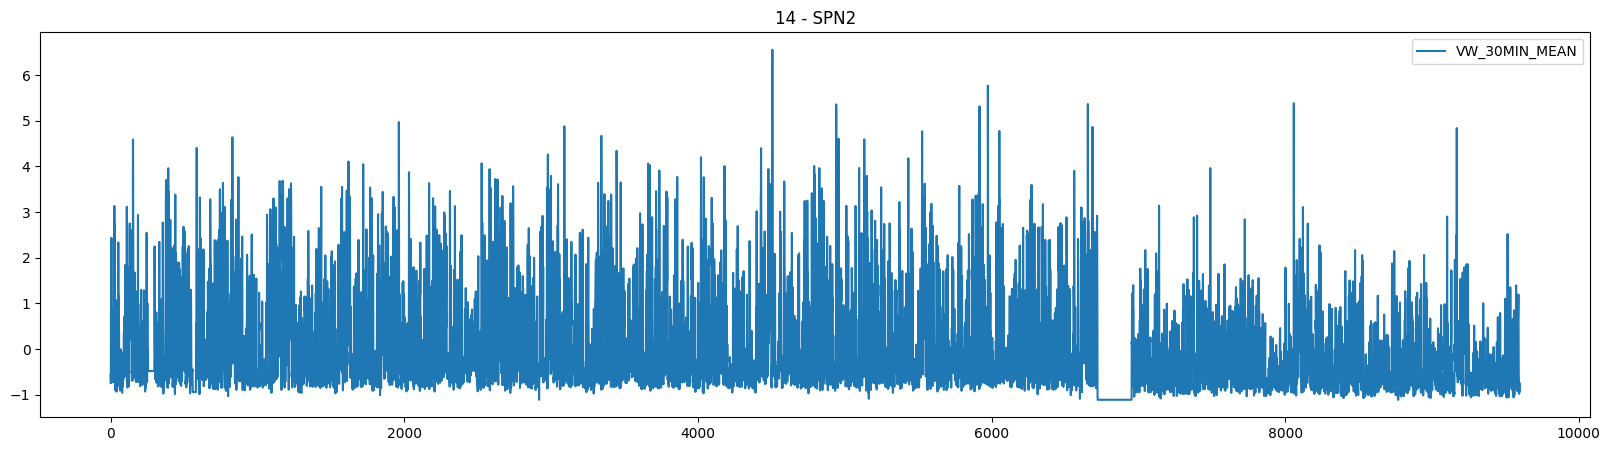

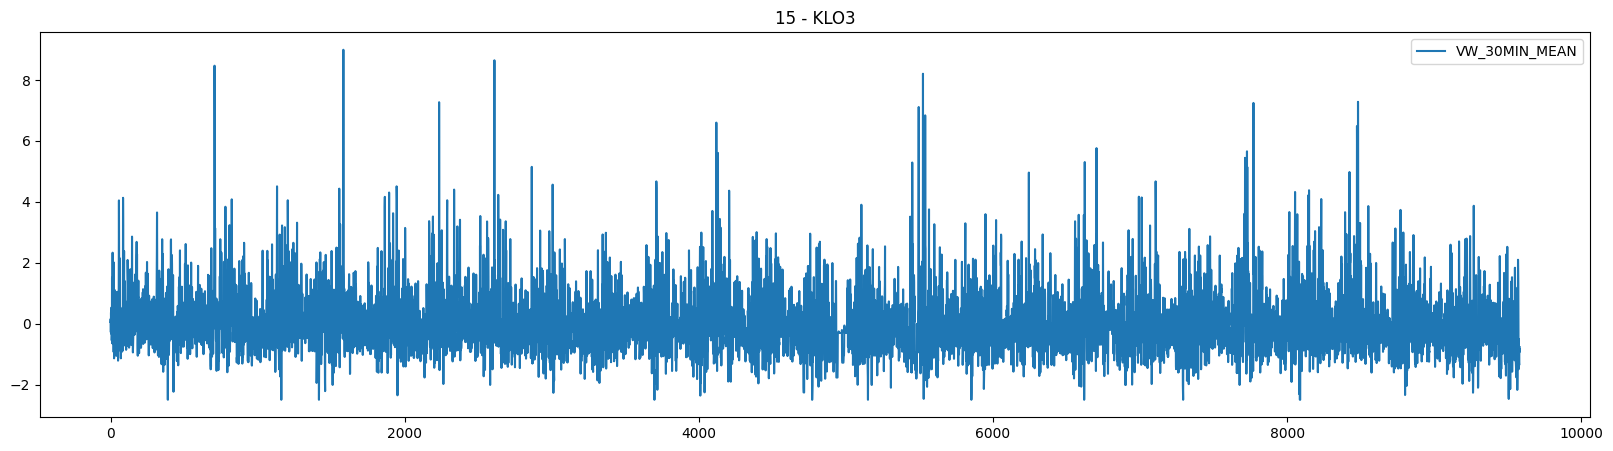

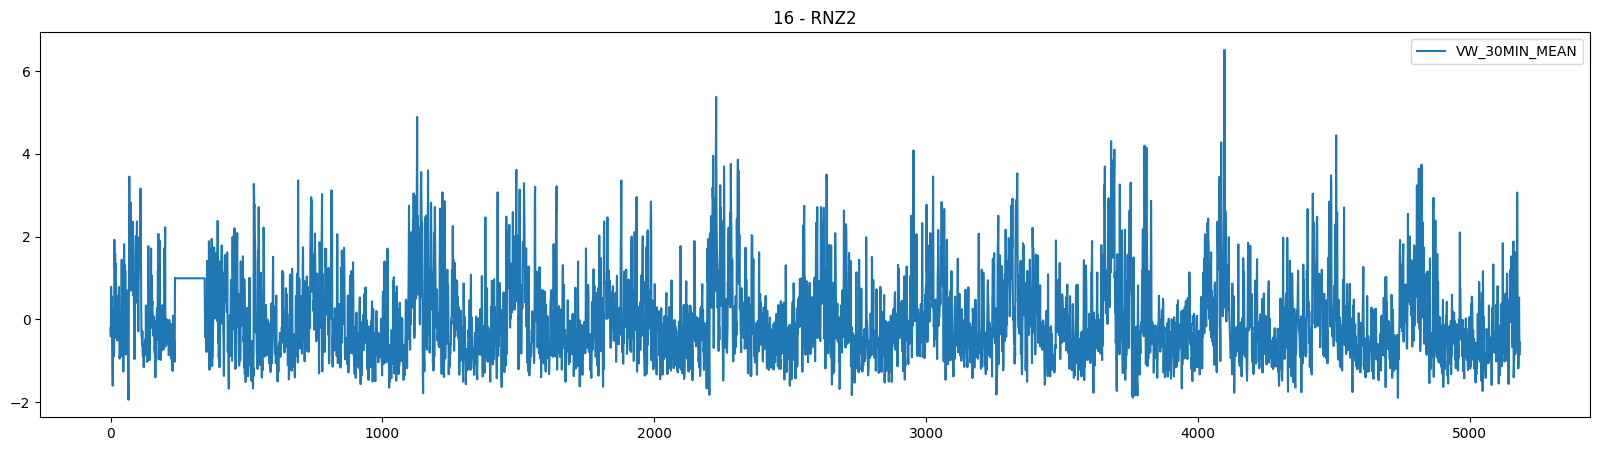

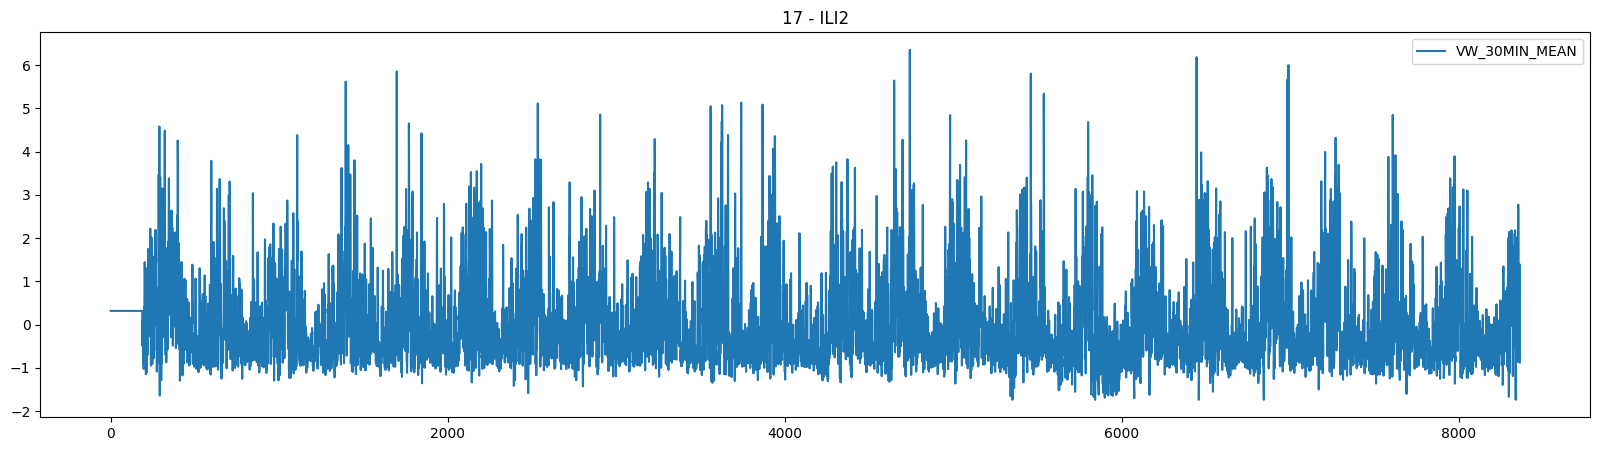

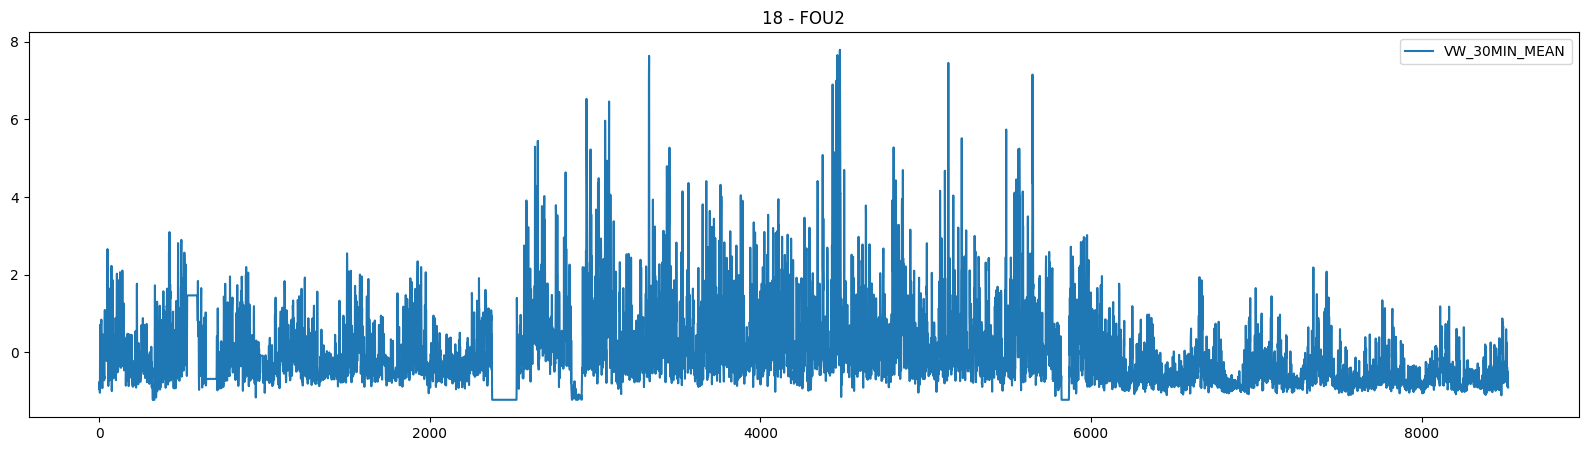

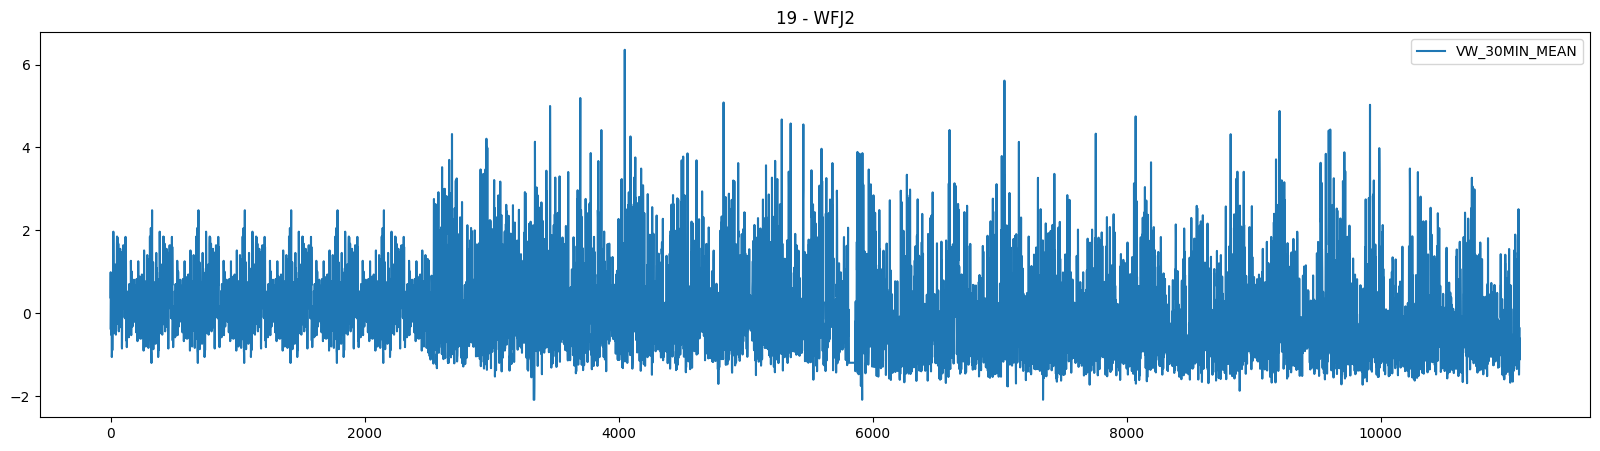

In [71]:
import matplotlib.pyplot as plt
cols = [
    # 'TSS_30MIN_MEAN',
    # 'TS0_30MIN_MEAN',
    # 'RSWR_30MIN_MEAN',
    # 'TA_30MIN_MEAN',
    'VW_30MIN_MEAN'
]

for i, t in enumerate(dfs):
    # if i != 1:
    #     continue
    features, _, _, _ = get_features_and_targets(t, len(t), cols, 'no_snow')

    plt.figure(figsize=(20, 5))
    for j, f in enumerate(features.T.tolist()):
        plt.plot(t.index, f, label=cols[j])
        plt.title(f"{i} - {t.iloc[0]['station_code']}")
        plt.legend()

    # features.plot(x=t.index)
    plt.show()